# Проект модуля «Детектирование аномалий»

In [4]:
from bs4 import BeautifulSoup
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import re
import pandas as pd  # Библиотека для табличек
import time
from lxml import html
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
import scipy
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Посмотрим на наш датасет.

In [58]:
tea_data = pd.read_csv("./tea_demand.csv", sep='\t', low_memory=False)

In [59]:
tea_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   brand_id        459 non-null    int64 
 1   date            459 non-null    object
 2   receipts_count  459 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 10.9+ KB


In [60]:
tea_data.head(5)

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185


In [61]:
tea_data['date'] = pd.to_datetime(tea_data['date'], format='%Y-%m-%d')
tea_data.date.max() - tea_data.date.min()

Timedelta('152 days 00:00:00')

In [62]:
tea_data = tea_data.pivot_table(index="date", columns="brand_id", values="receipts_count")
tea_data.columns = ['lipton','ahmad','may']
tea_data.head(2)

,lipton,ahmad,may
date,,,
2016-07-01,622,234,98
2016-07-02,580,185,87


Данные по продажам занимают промежуток в 152 дня и год 2016.

## Парсинг

Получим список дат о датах проведения передачи «Что? Где? Когда?».

In [63]:
header = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36'} 

def parse_html_table(table):
    n_columns = 0
    n_rows = 0
    column_names = []

    # Find number of rows and columns
    # we also find the column titles if we can
    for row in table.find_all('tr'):

        # Determine the number of rows in the table
        td_tags = row.find_all('td')
        if len(td_tags) > 0:
            n_rows += 1
            if n_columns == 0:
                # Set the number of columns for our table
                n_columns = len(td_tags)

        # Handle column names if we find them
        th_tags = row.find_all('th')
        if len(th_tags) > 0 and len(column_names) == 0:
            for th in th_tags:
                column_names.append(th.get_text())

    # Safeguard on Column Titles
    if len(column_names) > 0 and len(column_names) != n_columns:
        raise Exception("Column titles do not match the number of columns")

    columns = column_names if len(
        column_names) > 0 else range(0, n_columns)
    df = pd.DataFrame(columns=columns,
                      index=range(0, n_rows))
    row_marker = 0
    for row in table.find_all('tr'):
        column_marker = 0
        columns = row.find_all('td')
        for column in columns:
            df.iat[row_marker, column_marker] = column.get_text()
            column_marker += 1
        if len(columns) > 0:
            row_marker += 1
    return df


def get_soup(url):
    counter = 0
    while True:
        counter += 1
        try:
            resp = requests.get(url, headers=header)
            resp.status_code
            resp_html_content = resp.content
            soup = BeautifulSoup(resp_html_content, 'html.parser')
            res = soup
        except:
            res = None
        if counter > 2 or res != None:
            break
        else:
            time.sleep(3)
    return res

year_='2016'

url = f'http://chgk.tvigra.ru/letopis/?{year_}'
soup = get_soup(url)
table_ = soup.find('td', attrs = { 'rowspan':'2','valign':'top','width':'690'} ).find('table').find('table')

dft = parse_html_table(table_)

sessions_list =  dft.loc[1].sum().split('\n')
sessions_list = pd.Series(sessions_list)
sessions_list = sessions_list.drop(sessions_list.index[sessions_list==''])

month_dict = {'марта':'Mar', 'апреля': 'Apr', 'мая':'May', 'июня': 'Jun', 'августа': 'Aug', 'сентября':'Sep', 'октября': 'Oct', 'ноября':'Nov', 'декабря': 'Dec' }

def rus_months(str_):
    s0 = str_.split()[0]
    s1 = str_.split()[1]
    if s1 in month_dict:
        res = '-'.join([s0, month_dict[s1], year_])
    else:
        res = str_  
    return res
sessions_list = sessions_list.apply(rus_months)  
sessions_list = pd.to_datetime(sessions_list, format='%d-%b-%Y')
sessions_list.head()

1   2016-03-27
2   2016-04-03
3   2016-04-10
4   2016-04-17
5   2016-04-24
dtype: datetime64[ns]

Нас будут интересовать дни сразу после игровых сессий, когда предполагается наиболее вероятное воздействие рекламы:

In [64]:
tea_data['sessions'] = tea_data[tea_data.index.isin(sessions_list)]['ahmad']
tea_data['days_after_session']=tea_data['sessions'].shift(1)
tea_data.loc[tea_data['days_after_session'].notna(), 'days_after_session'] = tea_data['ahmad']

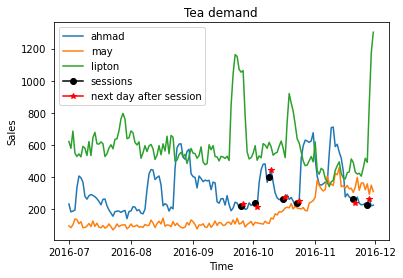

In [65]:
plt.plot(tea_data.index, tea_data['ahmad'], label = 'ahmad')
plt.plot(tea_data.index, tea_data['may'], label = 'may')
plt.plot(tea_data.index, tea_data['lipton'], label = 'lipton')
plt.plot(tea_data.index, tea_data['sessions'], color = 'black', label = 'sessions', marker = 'o')
plt.plot(tea_data.index, tea_data['days_after_session'], color = 'red', label = 'next day after session', marker = '*')

plt.title('Tea demand')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

Попробуем построить модель прогнозирующую ряд 'ahmad' на основе прошлых данных самого ряда, а также экзогенных рядов 'lipton' и 'may'

In [66]:
steps=-1
dataset_for_prediction = tea_data.drop(columns=['sessions','days_after_session']).copy()
dataset_for_prediction['Actual'] = dataset_for_prediction['ahmad'].shift(steps)
dataset_for_prediction = dataset_for_prediction.dropna()

Так как мы попробуем построить прогнозную модель с экзогенными переменными, то необходимо нормализовать признаки:

In [67]:
# normalizing input features
sc = MinMaxScaler(feature_range=(0, 1))
sc_in = sc
scaled_input = sc_in.fit_transform(dataset_for_prediction[['lipton',  'may']]) #'ahmad'
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

sc_out = sc
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [68]:
y.index=dataset_for_prediction.index
X.index = dataset_for_prediction.index
X.columns = ['lipton', 'may']
y.columns = ['next_day_ahmad']
df_sc = X.copy()
df_sc['ahmad'] = y.shift(1)
df_sc['sessions'] = df_sc[df_sc.index.isin(sessions_list)]['ahmad']
df_sc['days_after_session']=df_sc[df_sc.index.isin(tea_data[tea_data['days_after_session'].notna()].index)]['ahmad']

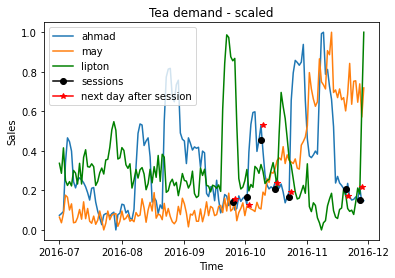

In [69]:
plt.plot(y.index, y.next_day_ahmad, label = 'ahmad')
plt.plot(df_sc.index, df_sc['may'], label = 'may')
plt.plot(df_sc.index, df_sc['lipton'], color = 'green', label = 'lipton')
plt.plot(df_sc.index, df_sc['sessions'], color = 'black', label = 'sessions', marker = 'o')
plt.plot(df_sc.index, df_sc['days_after_session'], color = 'red', label = 'next day after session', marker = '*')

plt.title('Tea demand - scaled')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

Посмотрим стационарен ли ряд. Проведем тест Адфуллера для провери стационарности ряда.

In [70]:
from statsmodels.tsa.stattools import adfuller

def test_adf(series):
    X = y.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print ("Ряд стационарен")
    else:
        print ("Ряд не стационарен")

In [71]:
test_adf(y)

ADF Statistic: -2.203225
p-value: 0.205077
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578
Ряд не стационарен


Продифференцируем ряд и проверим гипотезу о стационарности.

In [72]:
test_adf(y.diff())

ADF Statistic: -2.203225
p-value: 0.205077
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578
Ряд не стационарен


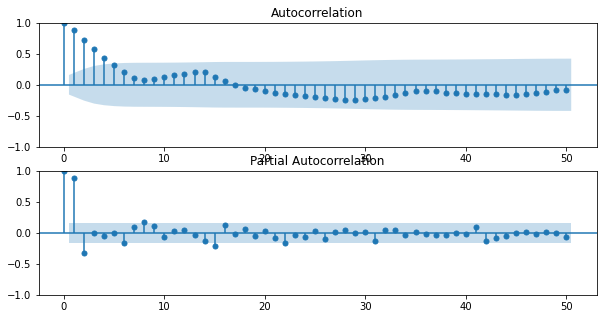

In [73]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y, lags=50, ax=ax[1], method='ywm')
plt.show()

In [74]:
y = y.asfreq('D')
X = X.asfreq('D')

In [75]:
import statsmodels.api as sm
from itertools import product
from tqdm.notebook import tqdm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

def write_predict(X: pd.DataFrame, y: pd.DataFrame):
    # Initial approximation of parameters
    Qs = range(0, 2)
    qs = range(0, 2)
    Ps = range(0, 2)
    ps = range(0, 2)
    S = [5,7]
    D=1
    d=1
    parameters = product(ps, qs, Ps, Qs,S)
    parameters_list = list(parameters)
    
    # Best Model Selection
    results = []
    best_aic = float("inf")
    for param in tqdm(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(
                endog = y, exog = X, order=(param[0], d, param[1]),# 
                seasonal_order=(param[2], D, param[3], param[4]),
                initialization='approximate_diffuse', 
                enforce_invertibility=False, 
                enforce_stationarity=False
                ).fit(disp=False)
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
            print(aic)
        results.append([param, model.aic])
    
    # Writing of the predictions for training data
    y['predict'] = best_model.predict()
    y['predict'].fillna(0, inplace=True)
    #y['pred_errors'] = best_model.resid

    print(f'p:{best_param[0]},d:{d}, q:{best_param[1]}')
    print(f'P:{best_param[2]},D:{D}, Q:{best_param[3]}, S:{best_param[4]}')
# Calling of the function
write_predict(X, y)

  0%|          | 0/32 [00:00<?, ?it/s]

-38.2175813468899
-118.13144663139363
p:0,d:1, q:0
P:0,D:1, Q:1, S:5


Вернемся обратно к исходной шкале значений:

In [76]:
X = pd.DataFrame(sc_in.inverse_transform(X))
for col in y.columns:
    y[col] = sc_out.inverse_transform(y[col].values.reshape(-1, 1))

In [78]:
X.index = dataset_for_prediction.index
X.columns = ['lipton',  'may']
df_sc = X.copy()
df_sc['ahmad'] = dataset_for_prediction['ahmad']
df_sc['sessions'] = df_sc[df_sc.index.isin(sessions_list)]['ahmad']
df_sc['days_after_session']=df_sc[df_sc.index.isin(tea_data[tea_data['days_after_session'].notna()].index)]['ahmad']

In [79]:
y.head(2)

,next_day_ahmad,predict
date,,
2016-07-01,185.0,119.977734
2016-07-02,190.0,186.955449


In [80]:
df_sc.head(2)

,lipton,may,ahmad,sessions,days_after_session
date,,,,,
2016-07-01,334.720818,179.757106,234,NaN,NaN
2016-07-02,305.962696,163.583979,185,NaN,NaN


Так как мы получаем предсказанное значение за день до реального, то для расчета случившихся ошибок и определения их дат надо сместить данные y на один день

In [81]:
y = y.shift(1) 

In [82]:
y.head(2)

,next_day_ahmad,predict
date,,
2016-07-01,NaN,NaN
2016-07-02,185.0,119.977734


Заполним появившийся от сдвига NaN

In [83]:
y = y.fillna(df_sc['ahmad'].head(1).values[0]) 

In [84]:
from statsmodels.tools.eval_measures import rmse

error_p=rmse(y['predict'],y['next_day_ahmad'])
error_p

63.46817555846412

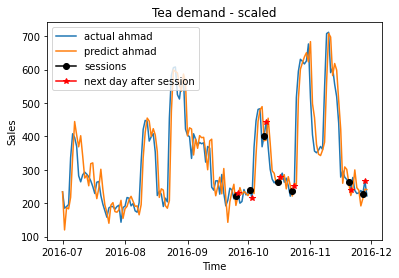

In [85]:
plt.plot(y.index, y['next_day_ahmad'], label = 'actual ahmad')
plt.plot(y.index, y['predict'], label = 'predict ahmad')
plt.plot(df_sc.index, df_sc['sessions'], color = 'black', label = 'sessions', marker = 'o')
plt.plot(df_sc.index, df_sc['days_after_session'], color = 'red', label = 'next day after session', marker = '*')

plt.title('Tea demand - scaled')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [86]:
pred_errors = abs(y['next_day_ahmad'] - y['predict']).to_numpy()

Общий подход к обнаружению аномалий заключается в том, чтобы решить задачу по отделению "нормального" от "аномального". Построив модель предсказывающего поведение временного ряда "в целом" можно считать аномалиями те точки временного ряда, которые "сильно" отклоняются от значения предсказанного моделью. Весь вопрос что такое "сильно". Обычно такие задачи решаются статистически на обучающей выборке, когда разработчик знает когда пришел полезный сигнал, а когда произошло ложное срабатывание. Здесь у нас нет такой возможности, поэтому понятие "нормальности" будем применять к ошибкам предсказания, определяя насколько вероятно аномальное поведение исходя из расчитанной ошибки. Можно по-разному задавать пороги для различения аномального выброса временной последовательности от ее нормального значения. Используют и квадратичные ошибки и MAPE и абсолютные ошибки предсказания. Порог в итоге тоже может задаваться и исходя из межквартильного интервала или из стандартных отклонениий.

<AxesSubplot:>

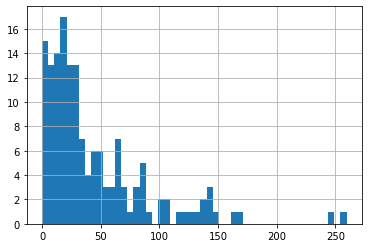

In [87]:
pd.Series(pred_errors).hist(bins=50)

Определим, что аномальным поведением будет когда абсолютная ошибка превысит Q3 + 1.5 * IQR 

In [88]:
Q1 = np.percentile(pred_errors, 25, interpolation = 'midpoint')
Q2 = np.percentile(pred_errors, 50, interpolation = 'midpoint')
Q3 = np.percentile(pred_errors, 75, interpolation = 'midpoint')
IQR = Q3 - Q1
up_lim = Q3 + 1.5 * IQR
print(up_lim)

133.8843298764673


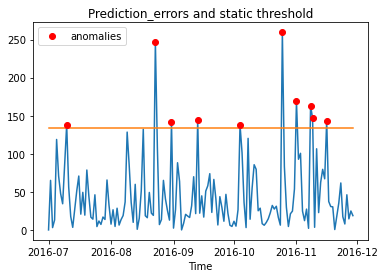

In [89]:
pred_error_threshold = up_lim # Можно задавать порог, например, и так: np.mean(pred_errors) + 3 * np.std(pred_errors)
pred_error_threshold = np.zeros(len(pred_errors))+pred_error_threshold

anomaly_idx = np.where(pred_errors>pred_error_threshold)[0]

plt.plot(y.index,pred_errors)
plt.plot(y.index,pred_error_threshold)
plt.plot(y.iloc[anomaly_idx].index,pred_errors[anomaly_idx], color = 'red', label = 'anomalies', marker = 'o', linestyle = 'None')
plt.title('Prediction_errors and static threshold')
plt.xlabel('Time')
plt.legend()
plt.show()


y['anomaly_detected'] = None
y.iloc[anomaly_idx,2]= y.iloc[ anomaly_idx,0]

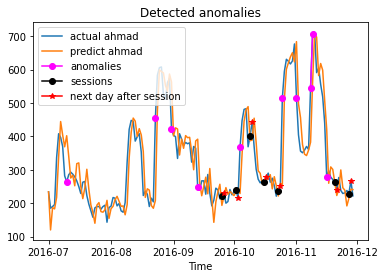

In [90]:
plt.plot(y.index, y['next_day_ahmad'], label = 'actual ahmad')
plt.plot(y.index, y['predict'], label = 'predict ahmad')
plt.plot(y.index, y['anomaly_detected'],  color = 'magenta', label = 'anomalies', marker = 'o')
plt.plot(df_sc.index, df_sc['sessions'], color = 'black', label = 'sessions', marker = 'o')
plt.plot(df_sc.index, df_sc['days_after_session'], color = 'red', label = 'next day after session', marker = '*')

plt.title('Detected anomalies')
plt.xlabel('Time')
plt.legend()
plt.show()

Есть ли в точках аномалий дни непосредственно после проведения игровых сессий с рекламой чая Ахмад?

In [91]:
df_sc[df_sc['days_after_session'].notna()].index

DatetimeIndex(['2016-09-26', '2016-10-03', '2016-10-10', '2016-10-17',
               '2016-10-24', '2016-11-21', '2016-11-28'],
              dtype='datetime64[ns]', name='date', freq=None)

In [92]:
y[y['anomaly_detected'].notna()].index

DatetimeIndex(['2016-07-10', '2016-08-23', '2016-08-31', '2016-09-13',
               '2016-10-04', '2016-10-25', '2016-11-01', '2016-11-08',
               '2016-11-09', '2016-11-16'],
              dtype='datetime64[ns]', name='date', freq=None)

Видно, что нет совпадений аномальных точек полученных из модели с днями после игровых сессий:

In [93]:
set(y[y['anomaly_detected'].notna()].index).intersection(set(df_sc[df_sc['days_after_session'].notna()].index))

set()

Можно еще попробовать другой способ определения аномалий, когда порог меняется динамически.

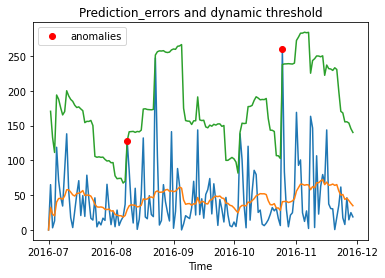

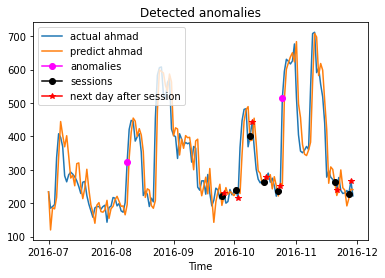

In [94]:
window = 14
std_coef = 3

# We use Series from pandas to calculate windowed errors
pred_errors_windowed = pd.Series(pred_errors).rolling(window=window, min_periods=1)
# Dynamic threshold for the training data
dynamic_threshold = pred_errors_windowed.mean() + std_coef * pred_errors_windowed.std()

anomaly_idx = np.where(pred_errors>dynamic_threshold)[0]
y['anomaly_detected'] = None
y.iloc[anomaly_idx,2]= y.iloc[ anomaly_idx,0]

plt.plot(y.index,pred_errors)
plt.plot(y.index,pred_errors_windowed.mean())
plt.plot(y.index,dynamic_threshold)
plt.plot(y.iloc[anomaly_idx].index,pred_errors[anomaly_idx], color = 'red', label = 'anomalies', marker = 'o', linestyle = 'None')
plt.title('Prediction_errors and dynamic threshold')
plt.xlabel('Time')
plt.legend()
plt.show()

plt.plot(y.index, y['next_day_ahmad'], label = 'actual ahmad')
plt.plot(y.index, y['predict'], label = 'predict ahmad')
plt.plot(y.index, y['anomaly_detected'],  color = 'magenta', label = 'anomalies', marker = 'o')
plt.plot(df_sc.index, df_sc['sessions'], color = 'black', label = 'sessions', marker = 'o')
plt.plot(df_sc.index, df_sc['days_after_session'], color = 'red', label = 'next day after session', marker = '*')
plt.title('Detected anomalies')
plt.xlabel('Time')
plt.legend()
plt.show()

Видно, что нет совпадений аномальных точек полученных из модели с днями после игровых сессий:

In [95]:
set(y[y['anomaly_detected'].notna()].index).intersection(set(df_sc[df_sc['days_after_session'].notna()].index))

set()

<AxesSubplot:xlabel='ahmad'>

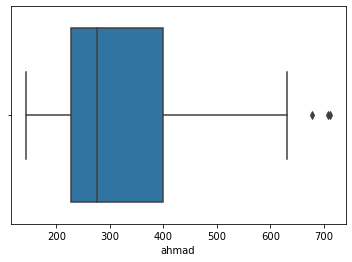

In [97]:
sns.boxplot(tea_data['ahmad'])

In [99]:
days_after_session = tea_data[tea_data.days_after_session.notna()]['days_after_session'].to_list()
days_after_session

[232.0, 216.0, 444.0, 279.0, 253.0, 241.0, 267.0]

In [101]:
iqr = scipy.stats.iqr(tea_data['ahmad'])
outliers = tea_data[tea_data['ahmad']>np.percentile(tea_data['ahmad'], 75)+1.5*iqr]['ahmad'].to_list()
outliers

[677, 708, 712]

Нет совпадений аномалий роста продаж после игровых сессий:

In [102]:
set(days_after_session).intersection(set(outliers))

set()

Попробуем продифферинцировать ряд и построить Box Plot.

In [104]:
tea_data['diff'] = tea_data['ahmad'].diff()
tea_data = tea_data.drop(tea_data.index[0])
tea_data.loc[tea_data.days_after_session.notna(),'days_after_session'] = tea_data[tea_data.days_after_session.notna()]['diff']

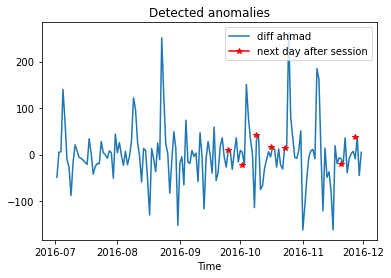

In [106]:
plt.plot(tea_data.index, tea_data['diff'], label = 'diff ahmad')
plt.plot(df_sc.index, tea_data['days_after_session'], color = 'red', label = 'next day after session', marker = '*')
plt.title('Detected anomalies')
plt.xlabel('Time')
plt.legend()
plt.show()

<AxesSubplot:xlabel='diff'>

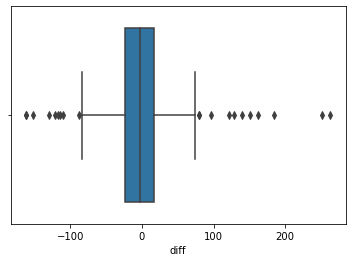

In [107]:
sns.boxplot(tea_data['diff'])

In [108]:
days_after_session = tea_data[tea_data.days_after_session.notna()]['diff'].to_list()
days_after_session

[9.0, -23.0, 43.0, 17.0, 15.0, -21.0, 38.0]

In [109]:
iqr = scipy.stats.iqr(tea_data['diff'] )
outliers = tea_data[(tea_data['diff']>np.percentile(tea_data['diff'], 75)+1.5*iqr)]['diff'].to_list()
outliers

[140.0, 122.0, 97.0, 251.0, 128.0, 151.0, 80.0, 263.0, 79.0, 185.0, 162.0]

Нет совпадений роста продаж после игровых сессий:

In [110]:
set(days_after_session).intersection(set(outliers))

set()

# Попытка кластеризации точек продаж (по всем трём вендорам)

In [112]:
# Несколько вспомогательных методов

def getDistanceByPoint(data, model):
    # Расчет расстояний от точек до центров кластеров
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

def getTransitionMatrix (df):
    # Расчет вероятностей перехода к следующему состоянию (глупая предсказывалка)
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    # Поиск аномалий в последовательности сигналов исходя из марковской матрицы переходов
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [114]:
df_tea = pd.read_csv("./tea_demand.csv",sep='\t')
df_tea['date'] = pd.to_datetime(df_tea['date'], format='%Y-%m-%d')

df_tea = df_tea.pivot_table(index="date", columns="brand_id", values="receipts_count")
df_tea.columns = ['lipton','ahmad','may']
df_tea['DayOfTheWeek'] = df_tea.index.dayofweek
df_tea['WeekDay'] = (df_tea['DayOfTheWeek'] < 5).astype(int)
outliers_fraction = 0.01
df_tea['date'] = df_tea.index # (df.index.astype(np.int64)/100000000000).view(np.int64)
df_tea.head(2)

,lipton,ahmad,may,DayOfTheWeek,WeekDay,date
date,,,,,,
2016-07-01,622,234,98,4,1,2016-07-01
2016-07-02,580,185,87,5,0,2016-07-02


In [115]:
df_tea = df_tea.reset_index(drop=True)

In [117]:
data = df_tea[['lipton','ahmad','may', 'DayOfTheWeek', 'WeekDay']]

# Нормализуем наши данные
starrd_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = starrd_scaler.transform(data)
data = pd.DataFrame(np_scaled)

# Уменьшим количество компонент
pca = PCA(n_components=2)
data = pca.fit_transform(data)

min_max_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = min_max_scaler.transform(data)
data = pd.DataFrame(np_scaled)
#data.index = df.index

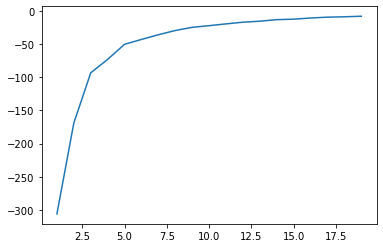

In [118]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=j, random_state = 10).fit(data) for j in n_cluster]
scores = [km.score(data) for km in kmeans]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [119]:
n_clusters = 5

In [120]:
df_tea['cluster'] = kmeans[n_clusters].predict(data)
df_tea['principal_feature1'] = data[0]
df_tea['principal_feature2'] = data[1]
df_tea['cluster'].value_counts()

2    52
0    32
4    28
1    21
5    12
3     8
Name: cluster, dtype: int64

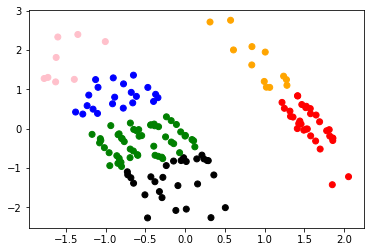

In [121]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df_tea['principal_feature1'], df_tea['principal_feature2'], c=df_tea["cluster"].apply(lambda x: colors[x]))
plt.show()

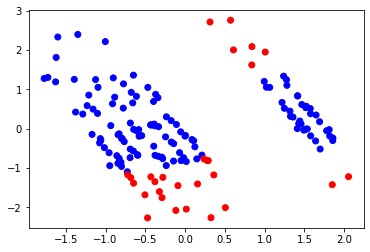

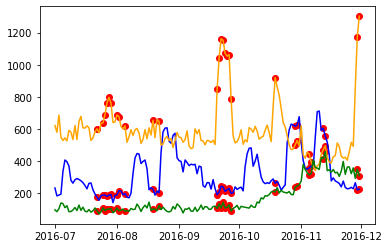

In [123]:
distance = getDistanceByPoint(data, kmeans[n_clusters])

number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# Считаем точку аномалией, если расстояние до центра кластера больше порога
df_tea['anomaly21'] = (distance >= 3.0).astype(int)

fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df_tea['principal_feature1'], df_tea['principal_feature2'], c=df_tea["anomaly21"].apply(lambda x: colors[x]))
plt.show()

fig, ax = plt.subplots()

a = df_tea.loc[df_tea['anomaly21'] == 1, ['date', 'ahmad']] #anomaly

ax.plot(df_tea['date'], df_tea['ahmad'], color='blue')
ax.scatter(a['date'],a['ahmad'], color='red')

b = df_tea.loc[df_tea['anomaly21'] == 1, ['date', 'lipton']] #anomaly

ax.plot(df_tea['date'], df_tea['lipton'], color='orange')
ax.scatter(a['date'],b['lipton'], color='red')

c = df_tea.loc[df_tea['anomaly21'] == 1, ['date', 'may']] #anomaly

ax.plot(df_tea['date'], df_tea['may'], color='green')
ax.scatter(a['date'],c['may'], color='red')

plt.show()

Посмотрим напоследок есть ли совпадения кластерных аномалий с игровыми сессиями.

In [125]:
df_tea.index = df_tea['date']
df_tea['sessions'] = df_tea[df_tea.index.isin(sessions_list)]['ahmad']
df_tea['days_after_session']=df_tea['sessions'].shift(1)
df_tea.loc[df_tea['days_after_session'].notna(), 'days_after_session'] = df_tea['ahmad']
df_tea.loc[df_tea.anomaly21==1,'anomaly21'] = df_tea['ahmad']
df_tea.loc[df_tea.anomaly21==0,'anomaly21'] = None
df_tea.head(2)

,lipton,ahmad,may,DayOfTheWeek,WeekDay,date,cluster,principal_feature1,principal_feature2,anomaly21,sessions,days_after_session
date,,,,,,,,,,,,
2016-07-01,622,234,98,4,1,2016-07-01,4,0.211612,-0.673605,NaN,NaN,NaN
2016-07-02,580,185,87,5,0,2016-07-02,0,1.578545,-0.183679,NaN,NaN,NaN


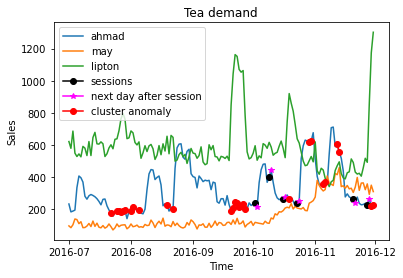

In [126]:
plt.plot(df_tea.index, df_tea['ahmad'], label = 'ahmad')
plt.plot(df_tea.index, df_tea['may'], label = 'may')
plt.plot(df_tea.index, df_tea['lipton'], label = 'lipton')
plt.plot(df_tea.index, df_tea['sessions'], color = 'black', label = 'sessions', marker = 'o')
plt.plot(df_tea.index, df_tea['days_after_session'], color = 'magenta', label = 'next day after session', marker = '*')
plt.plot(df_tea.index, df_tea['anomaly21'], color='red', marker = 'o', label = 'cluster anomaly')
plt.title('Tea demand')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [127]:
anomaly21 = set(df_tea[df_tea.anomaly21.notna()].index)
anomaly21

{Timestamp('2016-07-22 00:00:00'),
 Timestamp('2016-07-25 00:00:00'),
 Timestamp('2016-07-26 00:00:00'),
 Timestamp('2016-07-27 00:00:00'),
 Timestamp('2016-07-28 00:00:00'),
 Timestamp('2016-07-29 00:00:00'),
 Timestamp('2016-08-01 00:00:00'),
 Timestamp('2016-08-02 00:00:00'),
 Timestamp('2016-08-05 00:00:00'),
 Timestamp('2016-08-19 00:00:00'),
 Timestamp('2016-08-22 00:00:00'),
 Timestamp('2016-09-20 00:00:00'),
 Timestamp('2016-09-21 00:00:00'),
 Timestamp('2016-09-22 00:00:00'),
 Timestamp('2016-09-23 00:00:00'),
 Timestamp('2016-09-24 00:00:00'),
 Timestamp('2016-09-25 00:00:00'),
 Timestamp('2016-09-26 00:00:00'),
 Timestamp('2016-09-27 00:00:00'),
 Timestamp('2016-10-19 00:00:00'),
 Timestamp('2016-10-29 00:00:00'),
 Timestamp('2016-10-30 00:00:00'),
 Timestamp('2016-11-05 00:00:00'),
 Timestamp('2016-11-06 00:00:00'),
 Timestamp('2016-11-12 00:00:00'),
 Timestamp('2016-11-13 00:00:00'),
 Timestamp('2016-11-29 00:00:00'),
 Timestamp('2016-11-30 00:00:00')}

In [128]:
days_after_session = set(df_tea[df_tea.days_after_session.notna()].index)
days_after_session

{Timestamp('2016-09-26 00:00:00'),
 Timestamp('2016-10-03 00:00:00'),
 Timestamp('2016-10-10 00:00:00'),
 Timestamp('2016-10-17 00:00:00'),
 Timestamp('2016-10-24 00:00:00'),
 Timestamp('2016-11-21 00:00:00'),
 Timestamp('2016-11-28 00:00:00')}

In [129]:
anomaly21.intersection(days_after_session)

{Timestamp('2016-09-26 00:00:00')}

Есть одно совпадение кластерной аномалии и вчерашней игровой сессии, но эта аномалия - объединяет три марки чая и объясняется в этом месте резким скачком в чае Липтон, а вовсе не чаем Ахмад))